In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/standarddataset/daily-total-female-births.csv')
df['Date']= pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#df.index.freq='MS'

In [3]:
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Births  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


<AxesSubplot:xlabel='Date'>

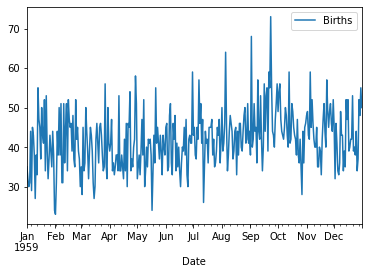

In [5]:
df.plot()

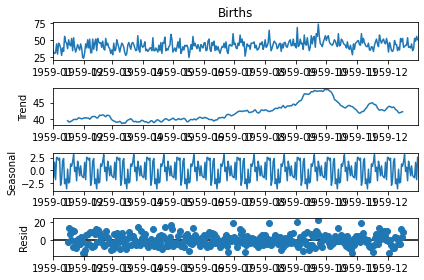

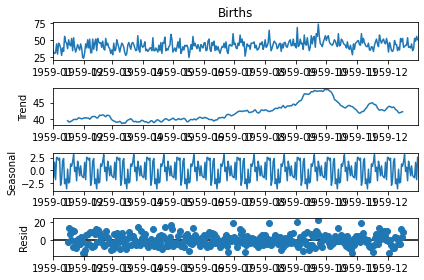

In [8]:
results = seasonal_decompose(df['Births'], freq=30)
results.plot()

In [57]:
len(df)

365

In [58]:
train = df.iloc[:334]
test = df.iloc[334:]

scaler = MinMaxScaler()

In [59]:
df.head(), df.tail()

(            Births
 Date              
 1959-01-01      35
 1959-01-02      32
 1959-01-03      30
 1959-01-04      31
 1959-01-05      44,
             Births
 Date              
 1959-12-27      37
 1959-12-28      52
 1959-12-29      48
 1959-12-30      55
 1959-12-31      50)

In [60]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.24],
       [0.18],
       [0.14],
       [0.16],
       [0.42],
       [0.12],
       [0.44],
       [0.4 ],
       [0.3 ],
       [0.08]])

# Recursive Strategy

In [61]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print(len(scaled_train),len(generator))

334 331


In [62]:
X,y = generator[0]
print(X.flatten())
print(y)

[0.24 0.18 0.14]
[[0.16]]


In [63]:
X.shape

(1, 3, 1)

In [64]:
n_input = 30
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.24],
         [0.18],
         [0.14],
         [0.16],
         [0.42],
         [0.12],
         [0.44],
         [0.4 ],
         [0.3 ],
         [0.08],
         [0.3 ],
         [0.2 ],
         [0.64],
         [0.48],
         [0.44],
         [0.28],
         [0.54],
         [0.4 ],
         [0.36],
         [0.58],
         [0.22],
         [0.6 ],
         [0.32],
         [0.18],
         [0.28],
         [0.4 ],
         [0.32],
         [0.24],
         [0.42],
         [0.3 ]]]),
 array([[0.02]]))

In [65]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.fit(generator, epochs=50, verbose=0)

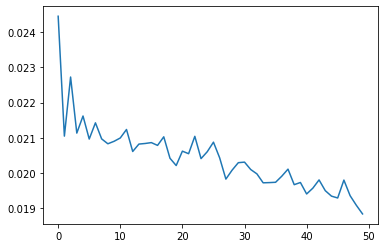

In [67]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [68]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.44866192]], dtype=float32)

In [69]:
scaled_test[0], scaled_test[1]

(array([0.44]), array([0.18]))

In [70]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.44866192], dtype=float32),
 array([0.4207771], dtype=float32),
 array([0.42874053], dtype=float32),
 array([0.45331267], dtype=float32),
 array([0.47370481], dtype=float32),
 array([0.46221972], dtype=float32),
 array([0.4469037], dtype=float32),
 array([0.4257197], dtype=float32),
 array([0.42619634], dtype=float32),
 array([0.4458045], dtype=float32),
 array([0.45531815], dtype=float32),
 array([0.45505753], dtype=float32),
 array([0.45317906], dtype=float32),
 array([0.4408328], dtype=float32),
 array([0.43537298], dtype=float32),
 array([0.4444328], dtype=float32),
 array([0.44938204], dtype=float32),
 array([0.43526292], dtype=float32),
 array([0.43062574], dtype=float32),
 array([0.44940996], dtype=float32),
 array([0.456703], dtype=float32),
 array([0.44699547], dtype=float32),
 array([0.43249628], dtype=float32),
 array([0.4275434], dtype=float32),
 array([0.42823577], dtype=float32),
 array([0.42770216], dtype=float32),
 array([0.43900308], dtype=float32),
 array([0.

In [71]:
test.head()

,Births
Date,
1959-12-01,45
1959-12-02,32
1959-12-03,46
1959-12-04,41
1959-12-05,34


In [72]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Date'>

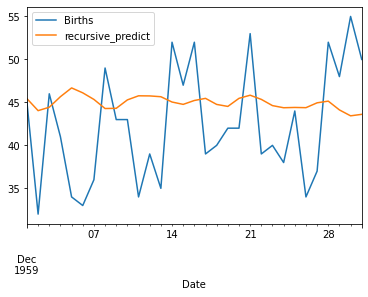

In [73]:
test.plot()

In [74]:
rmse = sqrt(mean_squared_error(test['Births'], test['recursive_predict']))
print(rmse)

7.317938748279149


In [75]:
test

,Births,recursive_predict
Date,,
1959-12-01,45,45.433096
1959-12-02,32,44.038856
1959-12-03,46,44.437027
1959-12-04,41,45.665633
1959-12-05,34,46.685241
1959-12-06,33,46.110986
1959-12-07,36,45.345185
1959-12-08,49,44.285985
1959-12-09,43,44.309817


# Direct Startegy

In [76]:
def generate_data(data, n_input, date):
    X, y = [], []
    for i in range(0,len(data)-(n_input+date)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(date-1)])
    return np.array(X), np.array(y)

In [77]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [78]:
n_input = 30
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.45847124], dtype=float32),
 array([0.44091842], dtype=float32),
 array([0.4380084], dtype=float32),
 array([0.45004892], dtype=float32),
 array([0.43813866], dtype=float32),
 array([0.42673734], dtype=float32),
 array([0.4540181], dtype=float32),
 array([0.41589212], dtype=float32),
 array([0.39457852], dtype=float32),
 array([0.4227163], dtype=float32),
 array([0.4503315], dtype=float32),
 array([0.4191557], dtype=float32),
 array([0.4205649], dtype=float32),
 array([0.3823571], dtype=float32),
 array([0.41812462], dtype=float32),
 array([0.449288], dtype=float32),
 array([0.4313559], dtype=float32),
 array([0.40787762], dtype=float32),
 array([0.40805227], dtype=float32),
 array([0.43505317], dtype=float32),
 array([0.44764537], dtype=float32),
 array([0.40116796], dtype=float32),
 array([0.42411292], dtype=float32),
 array([0.43912187], dtype=float32),
 array([0.42758486], dtype=float32),
 array([0.44552368], dtype=float32),
 array([0.4318155], dtype=float32),
 array([0.43

In [79]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='Date'>

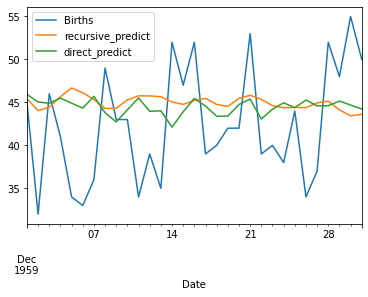

In [80]:
test.plot()

In [81]:
rmse = sqrt(mean_squared_error(test['Births'], test['direct_predict']))
print(rmse)

7.0276166285255535


In [82]:
test

,Births,recursive_predict,direct_predict
Date,,,
1959-12-01,45,45.433096,45.923562
1959-12-02,32,44.038856,45.045921
1959-12-03,46,44.437027,44.900420
1959-12-04,41,45.665633,45.502446
1959-12-05,34,46.685241,44.906933
1959-12-06,33,46.110986,44.336867
1959-12-07,36,45.345185,45.700904
1959-12-08,49,44.285985,43.794606
1959-12-09,43,44.309817,42.728926


# Direct Recursive Startegy

In [83]:
def generate_data(data, n_input, date):
    X, y = [], []
    for i in range(0,len(data)-(n_input+date)):
            X.append(data[i:i+n_input+(date-1)])
            y.append(data[i+n_input+(date-1)])
    return np.array(X), np.array(y)

In [84]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [85]:
n_input = 30
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.48620912], dtype=float32),
 array([0.42894372], dtype=float32),
 array([0.43820962], dtype=float32),
 array([0.45599803], dtype=float32),
 array([0.4354205], dtype=float32),
 array([0.42848915], dtype=float32),
 array([0.45462713], dtype=float32),
 array([0.42753527], dtype=float32),
 array([0.4331901], dtype=float32),
 array([0.41466773], dtype=float32),
 array([0.42738146], dtype=float32),
 array([0.3903641], dtype=float32),
 array([0.4121856], dtype=float32),
 array([0.41135654], dtype=float32),
 array([0.40256393], dtype=float32),
 array([0.4184107], dtype=float32),
 array([0.39961022], dtype=float32),
 array([0.4190445], dtype=float32),
 array([0.39943418], dtype=float32),
 array([0.42466033], dtype=float32),
 array([0.41314337], dtype=float32),
 array([0.38867322], dtype=float32),
 array([0.35376304], dtype=float32),
 array([0.40116832], dtype=float32),
 array([0.40784696], dtype=float32),
 array([0.4032667], dtype=float32),
 array([0.40430328], dtype=float32),
 array([

In [86]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Date'>

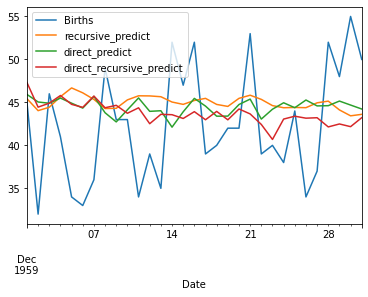

In [87]:
test.plot()

In [88]:
rmse = sqrt(mean_squared_error(test['Births'], test['direct_recursive_predict']))
print(rmse)

7.000326287005898


In [89]:
test

,Births,recursive_predict,direct_predict,direct_recursive_predict
Date,,,,
1959-12-01,45,45.433096,45.923562,47.310456
1959-12-02,32,44.038856,45.045921,44.447186
1959-12-03,46,44.437027,44.900420,44.910481
1959-12-04,41,45.665633,45.502446,45.799902
1959-12-05,34,46.685241,44.906933,44.771026
1959-12-06,33,46.110986,44.336867,44.424457
1959-12-07,36,45.345185,45.700904,45.731356
1959-12-08,49,44.285985,43.794606,44.376763
1959-12-09,43,44.309817,42.728926,44.659505


# MIMO

In [90]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [91]:
n_input = 30
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [92]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [93]:
model.fit(X, y, epochs=50, verbose=0)

In [94]:
model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_66 (Dense)             (None, 31)                6231      
Total params: 167,831
Trainable params: 167,831
Non-trainable params: 0
_________________________________________________________________


In [95]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [96]:
res.shape

(31, 1)

In [97]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [98]:
test

,Births,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
Date,,,,,
1959-12-01,45,45.433096,45.923562,47.310456,43.337818
1959-12-02,32,44.038856,45.045921,44.447186,42.942944
1959-12-03,46,44.437027,44.900420,44.910481,43.339504
1959-12-04,41,45.665633,45.502446,45.799902,43.317394
1959-12-05,34,46.685241,44.906933,44.771026,43.334709
1959-12-06,33,46.110986,44.336867,44.424457,43.882294
1959-12-07,36,45.345185,45.700904,45.731356,43.163670
1959-12-08,49,44.285985,43.794606,44.376763,42.673107
1959-12-09,43,44.309817,42.728926,44.659505,43.240517


<AxesSubplot:xlabel='Date'>

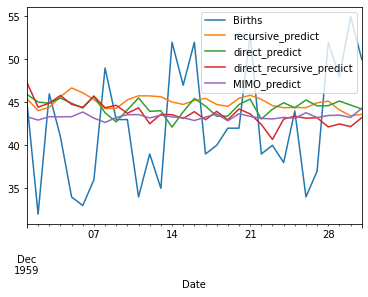

In [99]:
test.plot()

In [100]:
rmse = sqrt(mean_squared_error(test['Births'], test['MIMO_predict']))
print(rmse)

6.643598110294592


# Direct MIMO

In [101]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [102]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [103]:
n_input = 30
n_features = 1
test_predictions = []

q = int(len(scaled_test)/5)

n_output = q

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.45188794, 0.46145445, 0.4594586 , 0.4719751 , 0.477608  ,
         0.46210837]], dtype=float32),
 array([[0.42658505, 0.4495101 , 0.42052066, 0.43225917, 0.44106388,
         0.43995005]], dtype=float32),
 array([[0.411441  , 0.4110643 , 0.43014038, 0.42014542, 0.43354005,
         0.44083363]], dtype=float32),
 array([[0.44547486, 0.4460082 , 0.44903517, 0.45722637, 0.45598346,
         0.45735106]], dtype=float32),
 array([[0.4241643 , 0.42859173, 0.4291557 , 0.43597478, 0.42929247,
         0.42802647]], dtype=float32),
 array([[0.41297233, 0.41450593, 0.4076697 , 0.4061127 , 0.4133526 ,
         0.41386944]], dtype=float32)]

In [104]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [112]:
res = np.array(res[:31])
res = res.reshape((res.shape[0],1))
res.shape

(31, 1)

In [113]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [114]:
test

,Births,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
Date,,,,,,
1959-12-01,45,45.433096,45.923562,47.310456,43.337818,45.594398
1959-12-02,32,44.038856,45.045921,44.447186,42.942944,46.072723
1959-12-03,46,44.437027,44.900420,44.910481,43.339504,45.972927
1959-12-04,41,45.665633,45.502446,45.799902,43.317394,46.598755
1959-12-05,34,46.685241,44.906933,44.771026,43.334709,46.880402
1959-12-06,33,46.110986,44.336867,44.424457,43.882294,46.105419
1959-12-07,36,45.345185,45.700904,45.731356,43.163670,44.329254
1959-12-08,49,44.285985,43.794606,44.376763,42.673107,45.475502
1959-12-09,43,44.309817,42.728926,44.659505,43.240517,44.026031


<AxesSubplot:xlabel='Date'>

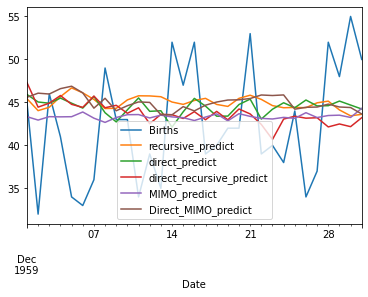

In [115]:
test.plot()

In [116]:
rmse = sqrt(mean_squared_error(test['Births'], test['Direct_MIMO_predict']))
print(rmse)

7.375259403178938


In [119]:
rec_err = abs(test['Births'] - test['recursive_predict'])
dir_err = abs(test['Births'] - test['direct_predict'])
dir_rec_err = abs(test['Births'] - test['direct_recursive_predict'])
mimo_err = abs(test['Births'] - test['MIMO_predict'])
dir_mimo_err = abs(test['Births'] - test['Direct_MIMO_predict'])

In [120]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [121]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
Date,,,,,
1959-12-01,0.433096,0.923562,2.310456,1.662182,0.594398
1959-12-02,12.038856,13.045921,12.447186,10.942944,14.072723
1959-12-03,1.562973,1.099580,1.089519,2.660496,0.027073
1959-12-04,4.665633,4.502446,4.799902,2.317394,5.598755
1959-12-05,12.685241,10.906933,10.771026,9.334709,12.880402
1959-12-06,13.110986,11.336867,11.424457,10.882294,13.105419
1959-12-07,9.345185,9.700904,9.731356,7.163670,8.329254
1959-12-08,4.714015,5.205394,4.623237,6.326893,3.524498
1959-12-09,1.309817,0.271074,1.659505,0.240517,1.026031


<AxesSubplot:xlabel='Date'>

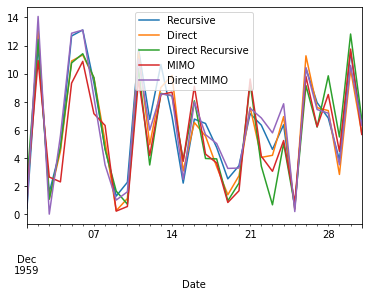

In [122]:
errors.plot()